In [1]:
import torch
import pandas as pd
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
import copy
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

Using device: cuda


In [2]:
mnist_df = pd.read_csv('mnist_train.csv')
mnist_df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
mnist_test_df = pd.read_csv('mnist_test.csv')
mnist_test_df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train a base model on the whole dataset

In [4]:
mnist_X = mnist_df.drop(columns=["label"]).values
mnist_y = mnist_df['label'].values

In [5]:
mnist_test_X = mnist_test_df.drop(columns=["label"]).values
mnist_test_y = mnist_test_df['label'].values

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx].reshape(28, 28) / 255.0
        img = torch.tensor(img).unsqueeze(0)
        img = img.repeat(3, 1, 1)

        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        label = torch.tensor(self.y[idx], dtype=torch.long)
        return img, label
    

train_dataset = MNISTDataset(mnist_X, mnist_y)
test_dataset = MNISTDataset(mnist_test_X, mnist_test_y)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/tmp/ipykernel_5678/2126796601.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:213.)
  self.y = torch.as_tensor(y, dtype=torch.long)


In [7]:
base_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
base_model.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

In [8]:
base_model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

In [10]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

base_loss_list = []
base_accuracy_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    base_model.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = base_model(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    base_loss_list.append(avg_train_loss)


    base_model.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = base_model(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    base_accuracy_list.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(base_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   

Epoch 1/1000


/tmp/ipykernel_5678/2126796601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
/tmp/ipykernel_5678/2126796601.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.y[idx], dtype=torch.long)


Epoch 1/1000, Train Loss: 0.0690, Val Loss: 0.0318, Val Accuracy: 0.9895
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0298, Val Loss: 0.0525, Val Accuracy: 0.9855
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0264, Val Loss: 0.0573, Val Accuracy: 0.9850
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0224, Val Loss: 0.0234, Val Accuracy: 0.9928
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0192, Val Loss: 0.0318, Val Accuracy: 0.9907
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0177, Val Loss: 0.0834, Val Accuracy: 0.9780
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0203, Val Loss: 0.0173, Val Accuracy: 0.9953
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0149, Val Loss: 0.0367, Val Accuracy: 0.9895
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0136, Val Loss: 0.0211, Val Accuracy: 0.9947
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0142, Val Loss: 0.0384, Val Accuracy: 0.9899
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0132, Val Loss: 0.0300, Val Accuracy: 0.9924
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0094, Val Loss: 0.03

In [11]:
with torch.no_grad():
    base_model.load_state_dict(best_model_weights)
    base_model.eval()
    base_model.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = base_model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(mnist_test_y, y_pred)
conf_matrix = confusion_matrix(mnist_test_y, y_pred)
class_report = classification_report(mnist_test_y, y_pred)

/tmp/ipykernel_5678/2126796601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
/tmp/ipykernel_5678/2126796601.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.y[idx], dtype=torch.long)


Accuracy of base model = 0.9953


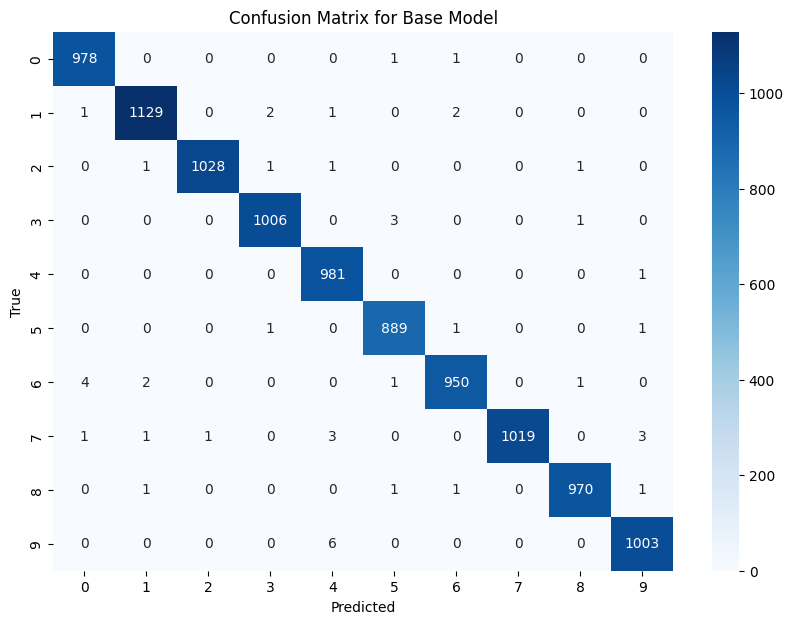

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.99      1.00      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [12]:
print(f"Accuracy of base model = {accuracy}")
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Base Model')
plt.show()
print(class_report)

Dividing training data into 10% labelled and 90% unlabelled

In [13]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for _, subset_idx in strat_split.split(mnist_X, mnist_y):
    labeled_X = mnist_X[subset_idx]
    y = mnist_y[subset_idx]
    unlabeled_X = mnist_X[_]

In [14]:
strat_split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test, train in strat_split1.split(labeled_X, y):
    X_train = labeled_X[train]
    y_train = y[train]
    X_val = labeled_X[test]
    y_val = y[test]

In [15]:
labeled_train_dataset = MNISTDataset(labeled_X, y)
train_loader = DataLoader(labeled_train_dataset, batch_size=64, shuffle=True)

val_dataset = MNISTDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

unlabeled_dataset = MNISTDataset(unlabeled_X, np.zeros(len(unlabeled_X)))
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)

In [16]:
model1 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

model1.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [17]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

loss_list_10 = []
accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    loss_list_10.append(avg_train_loss)


    model1.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   

Epoch 1/1000


/tmp/ipykernel_5678/2126796601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
/tmp/ipykernel_5678/2126796601.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.y[idx], dtype=torch.long)


Epoch 1/1000, Train Loss: 0.2635, Val Loss: 0.3937, Val Accuracy: 0.8819
Epoch 2/1000
Epoch 2/1000, Train Loss: 0.0514, Val Loss: 0.1478, Val Accuracy: 0.9557
Epoch 3/1000
Epoch 3/1000, Train Loss: 0.0346, Val Loss: 0.1113, Val Accuracy: 0.9667
Epoch 4/1000
Epoch 4/1000, Train Loss: 0.0218, Val Loss: 0.1708, Val Accuracy: 0.9475
Epoch 5/1000
Epoch 5/1000, Train Loss: 0.0163, Val Loss: 0.1322, Val Accuracy: 0.9613
Epoch 6/1000
Epoch 6/1000, Train Loss: 0.0178, Val Loss: 0.1096, Val Accuracy: 0.9669
Epoch 7/1000
Epoch 7/1000, Train Loss: 0.0133, Val Loss: 0.0885, Val Accuracy: 0.9734
Epoch 8/1000
Epoch 8/1000, Train Loss: 0.0135, Val Loss: 0.0707, Val Accuracy: 0.9827
Epoch 9/1000
Epoch 9/1000, Train Loss: 0.0193, Val Loss: 0.1289, Val Accuracy: 0.9735
Epoch 10/1000
Epoch 10/1000, Train Loss: 0.0200, Val Loss: 0.0543, Val Accuracy: 0.9842
Epoch 11/1000
Epoch 11/1000, Train Loss: 0.0218, Val Loss: 0.2099, Val Accuracy: 0.9537
Epoch 12/1000
Epoch 12/1000, Train Loss: 0.0261, Val Loss: 0.13

In [ ]:
pseudo_images_07 = []
pseudo_labels_07 = []

with torch.no_grad():
    model1.load_state_dict(best_model_weights)
    model1.eval()
    model1.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model1(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7
        mask_08 = conf >= 0.8
        mask_09 = conf >= 0.9

        pseudo_images_07.append(images[mask_07].cpu())
        pseudo_labels_07.append(preds[mask_07].cpu())

pseudo_images_07 = torch.cat(pseudo_images_07, dim=0)
pseudo_labels_07 = torch.cat(pseudo_labels_07, dim=0)


/tmp/ipykernel_5678/2126796601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
/tmp/ipykernel_5678/2126796601.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.y[idx], dtype=torch.long)


In [ ]:

pseudo_images_08 = []
pseudo_labels_08 = []

with torch.no_grad():
    model1.load_state_dict(best_model_weights)
    model1.eval()
    model1.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model1(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7
        mask_08 = conf >= 0.8
        mask_09 = conf >= 0.9


        pseudo_images_08.append(images[mask_08].cpu())
        pseudo_labels_08.append(preds[mask_08].cpu())


pseudo_images_08 = torch.cat(pseudo_images_08, dim=0)
pseudo_labels_08 = torch.cat(pseudo_labels_08, dim=0)

    

/tmp/ipykernel_6261/2126796601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
/tmp/ipykernel_6261/2126796601.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.y[idx], dtype=torch.long)


In [ ]:

pseudo_images_09 = []
pseudo_labels_09 = []

with torch.no_grad():
    model1.load_state_dict(best_model_weights)
    model1.eval()
    model1.to(device)

    for images, _ in unlabeled_loader:
        images = images.to(device)  
        outputs = model1(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7
        mask_08 = conf >= 0.8
        mask_09 = conf >= 0.9


        pseudo_images_09.append(images[mask_09].cpu())
        pseudo_labels_09.append(preds[mask_09].cpu())

pseudo_images_09 = torch.cat(pseudo_images_09, dim=0)
pseudo_labels_09 = torch.cat(pseudo_labels_09, dim=0)
    

/tmp/ipykernel_6261/2126796601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).unsqueeze(0)
/tmp/ipykernel_6261/2126796601.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.y[idx], dtype=torch.long)


In [ ]:
class PseudoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx].reshape(28, 28).astype("float32") / 255.0
        img = torch.tensor(img).unsqueeze(0)
        img = img.repeat(3, 1, 1)

        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        label = torch.tensor(self.y[idx], dtype=torch.long)
        return img, label
    
combined_dataset_07 = ConcatDataset([PseudoDataset(pseudo_images_07, pseudo_labels_07), labeled_train_dataset])
combined_loader_07 = DataLoader(combined_dataset_07, batch_size=64, shuffle=True)

combined_dataset_08 = ConcatDataset([PseudoDataset(pseudo_images_08, pseudo_labels_08), labeled_train_dataset])
combined_loader_08 = DataLoader(combined_dataset_08, batch_size=64, shuffle=True)

combined_dataset_09 = ConcatDataset([PseudoDataset(pseudo_images_09, pseudo_labels_09), labeled_train_dataset])
combined_loader_09 = DataLoader(combined_dataset_09, batch_size=64, shuffle=True)

In [ ]:
model1_07 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1_07.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model1_07.to(device)
loss_fn_07 = torch.nn.CrossEntropyLoss()
optimizer_07 = torch.optim.Adam(model1_07.parameters(), lr=0.001)

model1_08 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1_08.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model1_08.to(device)
loss_fn_08 = torch.nn.CrossEntropyLoss()
optimizer_08 = torch.optim.Adam(model1_08.parameters(), lr=0.001)

model1_09 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model1_09.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model1_09.to(device)
loss_fn_09 = torch.nn.CrossEntropyLoss()
optimizer_09 = torch.optim.Adam(model1_09.parameters(), lr=0.001)


In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1_07.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_07:
        optimizer_07.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1_07(X_batch)
        loss = loss_fn_07(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_07.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model1_07.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1_07(X_batch)
            test_loss = loss_fn_07(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1_07.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model1_07.load_state_dict(best_model_weights)


In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1_08.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_08:
        optimizer_08.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1_08(X_batch)
        loss = loss_fn_08(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_08.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model1_08.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1_08(X_batch)
            test_loss = loss_fn_08(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1_08.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model1_08.load_state_dict(best_model_weights)

In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model1_09.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_09:
        optimizer_09.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model1_09(X_batch)
        loss = loss_fn_09(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_09.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model1_09.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model1_09(X_batch)
            test_loss = loss_fn_09(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model1_09.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model1_09.load_state_dict(best_model_weights)

In [ ]:
with torch.no_grad():
    model1_07.eval()
    model1_07.to(device)
    model1_08.eval()
    model1_08.to(device)
    model1_09.eval()
    model1_09.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs_07 = model1_07(X_batch)
        outputs_08 = model1_08(X_batch)
        outputs_09 = model1_09(X_batch)

        preds_07 = torch.argmax(outputs_07, dim=1)
        preds_08 = torch.argmax(outputs_08, dim=1)
        preds_09 = torch.argmax(outputs_09, dim=1)


accuracy_07 = accuracy_score(mnist_test_y, preds_07)
conf_matrix_07 = confusion_matrix(mnist_test_y, preds_07)
class_report_07 = classification_report(mnist_test_y, preds_07)

accuracy_08 = accuracy_score(mnist_test_y, preds_08)
conf_matrix_08 = confusion_matrix(mnist_test_y, preds_08)
class_report_08 = classification_report(mnist_test_y, preds_08)

accuracy_09 = accuracy_score(mnist_test_y, preds_09)
conf_matrix_09 = confusion_matrix(mnist_test_y, preds_09)
class_report_09 = classification_report(mnist_test_y, preds_09)

In [ ]:
print(f"Accuracy of model trained with 10% labeled data and pseudo-labeling:")
print(f"0.7 Confidence Threshold: {accuracy_07}")
print(f"0.8 Confidence Threshold: {accuracy_08}")
print(f"0.9 Confidence Threshold: {accuracy_09}")

plt.figure(figsize=(30, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        sns.heatmap(conf_matrix_07, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.7 Threshold)')
    elif i == 1:
        sns.heatmap(conf_matrix_08, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.8 Threshold)')
    else:
        sns.heatmap(conf_matrix_09, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.9 Threshold)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.show()

print("Classification Report (0.7 Threshold):")
print(class_report_07)
print("\nClassification Report (0.8 Threshold):")
print(class_report_08)
print("\nClassification Report (0.9 Threshold):")
print(class_report_09)

Training a model on 20% labeled and 80% unlabeled data

In [ ]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for _, subset_idx in strat_split.split(mnist_X, mnist_y):
    labeled_X = mnist_X[subset_idx]
    y = mnist_y[subset_idx]
    unlabeled_X = mnist_X[_]

In [ ]:
strat_split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test, train in strat_split1.split(labeled_X, y):
    X_train = labeled_X[train]
    y_train = y[train]
    X_val = labeled_X[test]
    y_val = y[test]

In [ ]:
labeled_train_dataset = MNISTDataset(labeled_X, y)
train_loader = DataLoader(labeled_train_dataset, batch_size=64, shuffle=True)

val_dataset = MNISTDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

unlabeled_dataset = MNISTDataset(unlabeled_X, np.zeros(len(unlabeled_X)))
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)

In [ ]:
model2 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

model2.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

loss_list_10 = []
accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    loss_list_10.append(avg_train_loss)


    model2.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   

In [ ]:
pseudo_images_07 = []
pseudo_labels_07 = []
pseudo_images_08 = []
pseudo_labels_08 = []
pseudo_images_09 = []
pseudo_labels_09 = []

with torch.no_grad():
    model2.load_state_dict(best_model_weights)
    model2.eval()
    model2.to(device)

    for images, _ in unlabeled_X:
        images = images.to(device)
        outputs = model2(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7
        mask_08 = conf >= 0.8
        mask_09 = conf >= 0.9

        pseudo_images_07.append(images[mask_07].cpu())
        pseudo_labels_07.append(preds[mask_07].cpu())
        pseudo_images_08.append(images[mask_08].cpu())
        pseudo_labels_08.append(preds[mask_08].cpu())
        pseudo_images_09.append(images[mask_09].cpu())
        pseudo_labels_09.append(preds[mask_09].cpu())

pseudo_images_07 = torch.cat(pseudo_images_07, dim=0)
pseudo_labels_07 = torch.cat(pseudo_labels_07, dim=0)
pseudo_images_08 = torch.cat(pseudo_images_08, dim=0)
pseudo_labels_08 = torch.cat(pseudo_labels_08, dim=0)
pseudo_images_09 = torch.cat(pseudo_images_09, dim=0)
pseudo_labels_09 = torch.cat(pseudo_labels_09, dim=0)
    

In [ ]:
class PseudoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx].reshape(28, 28).astype("float32") / 255.0
        img = torch.tensor(img).unsqueeze(0)
        img = img.repeat(3, 1, 1)

        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        label = torch.tensor(self.y[idx], dtype=torch.long)
        return img, label
    
combined_dataset_07 = ConcatDataset([PseudoDataset(pseudo_images_07, pseudo_labels_07), labeled_train_dataset])
combined_loader_07 = DataLoader(combined_dataset_07, batch_size=64, shuffle=True)

combined_dataset_08 = ConcatDataset([PseudoDataset(pseudo_images_08, pseudo_labels_08), labeled_train_dataset])
combined_loader_08 = DataLoader(combined_dataset_08, batch_size=64, shuffle=True)

combined_dataset_09 = ConcatDataset([PseudoDataset(pseudo_images_09, pseudo_labels_09), labeled_train_dataset])
combined_loader_09 = DataLoader(combined_dataset_09, batch_size=64, shuffle=True)

In [ ]:
model2_07 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2_07.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model2_07.to(device)
loss_fn_07 = torch.nn.CrossEntropyLoss()
optimizer_07 = torch.optim.Adam(model2_07.parameters(), lr=0.001)

model2_08 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2_08.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model2_08.to(device)
loss_fn_08 = torch.nn.CrossEntropyLoss()
optimizer_08 = torch.optim.Adam(model2_08.parameters(), lr=0.001)

model2_09 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model2_09.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model2_09.to(device)
loss_fn_09 = torch.nn.CrossEntropyLoss()
optimizer_09 = torch.optim.Adam(model2_09.parameters(), lr=0.001)


In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2_07.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_07:
        optimizer_07.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2_07(X_batch)
        loss = loss_fn_07(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_07.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model2_07.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2_07(X_batch)
            test_loss = loss_fn_07(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2_07.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model2_07.load_state_dict(best_model_weights)


In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2_08.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_08:
        optimizer_08.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2_08(X_batch)
        loss = loss_fn_08(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_08.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model2_08.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2_08(X_batch)
            test_loss = loss_fn_08(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2_08.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model2_08.load_state_dict(best_model_weights)

In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model2_09.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_09:
        optimizer_09.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model2_09(X_batch)
        loss = loss_fn_09(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_09.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model2_09.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2_09(X_batch)
            test_loss = loss_fn_09(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model2_09.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model2_09.load_state_dict(best_model_weights)

In [ ]:
with torch.no_grad():
    model2_07.eval()
    model2_07.to(device)
    model2_08.eval()
    model2_08.to(device)
    model2_09.eval()
    model2_09.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs_07 = model2_07(X_batch)
        outputs_08 = model2_08(X_batch)
        outputs_09 = model2_09(X_batch)

        preds_07 = torch.argmax(outputs_07, dim=1)
        preds_08 = torch.argmax(outputs_08, dim=1)
        preds_09 = torch.argmax(outputs_09, dim=1)


accuracy_07 = accuracy_score(mnist_test_y, preds_07)
conf_matrix_07 = confusion_matrix(mnist_test_y, preds_07)
class_report_07 = classification_report(mnist_test_y, preds_07)

accuracy_08 = accuracy_score(mnist_test_y, preds_08)
conf_matrix_08 = confusion_matrix(mnist_test_y, preds_08)
class_report_08 = classification_report(mnist_test_y, preds_08)

accuracy_09 = accuracy_score(mnist_test_y, preds_09)
conf_matrix_09 = confusion_matrix(mnist_test_y, preds_09)
class_report_09 = classification_report(mnist_test_y, preds_09)

In [ ]:
print(f"Accuracy of model trained with 20% labeled data and pseudo-labeling:")
print(f"0.7 Confidence Threshold: {accuracy_07}")
print(f"0.8 Confidence Threshold: {accuracy_08}")
print(f"0.9 Confidence Threshold: {accuracy_09}")

plt.figure(figsize=(30, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        sns.heatmap(conf_matrix_07, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.7 Threshold)')
    elif i == 1:
        sns.heatmap(conf_matrix_08, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.8 Threshold)')
    else:
        sns.heatmap(conf_matrix_09, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.9 Threshold)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.show()

print("Classification Report (0.7 Threshold):")
print(class_report_07)
print("\nClassification Report (0.8 Threshold):")
print(class_report_08)
print("\nClassification Report (0.9 Threshold):")
print(class_report_09)

Training a model on 30% labeled and 70% unlabeled data

In [ ]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for _, subset_idx in strat_split.split(mnist_X, mnist_y):
    labeled_X = mnist_X[subset_idx]
    y = mnist_y[subset_idx]
    unlabeled_X = mnist_X[_]

In [ ]:
strat_split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test, train in strat_split1.split(labeled_X, y):
    X_train = labeled_X[train]
    y_train = y[train]
    X_val = labeled_X[test]
    y_val = y[test]

In [ ]:
labeled_train_dataset = MNISTDataset(labeled_X, y)
train_loader = DataLoader(labeled_train_dataset, batch_size=64, shuffle=True)

val_dataset = MNISTDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

unlabeled_dataset = MNISTDataset(unlabeled_X, np.zeros(len(unlabeled_X)))
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)

In [ ]:
model3 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)

model3.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

loss_list_10 = []
accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3(X_batch)
        loss = loss_fn(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_train_loss = epoch_loss / len(train_loader)
    loss_list_10.append(avg_train_loss)


    model3.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3(X_batch)
            test_loss = loss_fn(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")   

In [ ]:
pseudo_images_07 = []
pseudo_labels_07 = []
pseudo_images_08 = []
pseudo_labels_08 = []
pseudo_images_09 = []
pseudo_labels_09 = []

with torch.no_grad():
    model3.load_state_dict(best_model_weights)
    model3.eval()
    model3.to(device)

    for images, _ in unlabeled_X:
        images = images.to(device)
        outputs = model3(images)
        preds = F.softmax(outputs, dim=1)

        conf, preds = torch.max(preds, dim=1)
        mask_07 = conf >= 0.7
        mask_08 = conf >= 0.8
        mask_09 = conf >= 0.9

        pseudo_images_07.append(images[mask_07].cpu())
        pseudo_labels_07.append(preds[mask_07].cpu())
        pseudo_images_08.append(images[mask_08].cpu())
        pseudo_labels_08.append(preds[mask_08].cpu())
        pseudo_images_09.append(images[mask_09].cpu())
        pseudo_labels_09.append(preds[mask_09].cpu())

pseudo_images_07 = torch.cat(pseudo_images_07, dim=0)
pseudo_labels_07 = torch.cat(pseudo_labels_07, dim=0)
pseudo_images_08 = torch.cat(pseudo_images_08, dim=0)
pseudo_labels_08 = torch.cat(pseudo_labels_08, dim=0)
pseudo_images_09 = torch.cat(pseudo_images_09, dim=0)
pseudo_labels_09 = torch.cat(pseudo_labels_09, dim=0)
    

In [ ]:
class PseudoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = self.X[idx].reshape(28, 28).astype("float32") / 255.0
        img = torch.tensor(img).unsqueeze(0)
        img = img.repeat(3, 1, 1)

        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)

        label = torch.tensor(self.y[idx], dtype=torch.long)
        return img, label
    
combined_dataset_07 = ConcatDataset([PseudoDataset(pseudo_images_07, pseudo_labels_07), labeled_train_dataset])
combined_loader_07 = DataLoader(combined_dataset_07, batch_size=64, shuffle=True)

combined_dataset_08 = ConcatDataset([PseudoDataset(pseudo_images_08, pseudo_labels_08), labeled_train_dataset])
combined_loader_08 = DataLoader(combined_dataset_08, batch_size=64, shuffle=True)

combined_dataset_09 = ConcatDataset([PseudoDataset(pseudo_images_09, pseudo_labels_09), labeled_train_dataset])
combined_loader_09 = DataLoader(combined_dataset_09, batch_size=64, shuffle=True)

In [ ]:
model3_07 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3_07.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model3_07.to(device)
loss_fn_07 = torch.nn.CrossEntropyLoss()
optimizer_07 = torch.optim.Adam(model3_07.parameters(), lr=0.001)

model3_08 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3_08.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model3_08.to(device)
loss_fn_08 = torch.nn.CrossEntropyLoss()
optimizer_08 = torch.optim.Adam(model3_08.parameters(), lr=0.001)

model3_09 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model3_09.classifier[3] = torch.nn.Linear(in_features=1024, out_features=10)
model3_09.to(device)
loss_fn_09 = torch.nn.CrossEntropyLoss()
optimizer_09 = torch.optim.Adam(model3_09.parameters(), lr=0.001)


In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3_07.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_07:
        optimizer_07.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3_07(X_batch)
        loss = loss_fn_07(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_07.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model3_07.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3_07(X_batch)
            test_loss = loss_fn_07(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3_07.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model3_07.load_state_dict(best_model_weights)


In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3_08.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_08:
        optimizer_08.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3_08(X_batch)
        loss = loss_fn_08(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_08.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model3_08.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3_08(X_batch)
            test_loss = loss_fn_08(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3_08.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model3_08.load_state_dict(best_model_weights)

In [ ]:
epochs = 1000
best_model_loss = float('inf')
best_model_weights = None
patience = 7
patience_counter = 0

comb_loss_list_10 = []
comb_accuracy_list_10 = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model3_09.train()
    epoch_loss = 0.0

    batch = 0
    for X_batch, y_batch in combined_loader_09:
        optimizer_09.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model3_09(X_batch)
        loss = loss_fn_09(outputs, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_09.step()


    avg_train_loss = epoch_loss / len(train_loader)
    comb_loss_list_10.append(avg_train_loss)


    model3_09.eval()
    epoch_val_loss = 0.0
    epoch_val_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model3_09(X_batch)
            test_loss = loss_fn_09(outputs, y_batch)
            epoch_val_loss += test_loss.item()
            
            y_pred = torch.argmax(outputs, dim=1)
            accuracy = (y_pred == y_batch).float().mean()
            epoch_val_accuracy += accuracy.item()

    avg_val_loss = epoch_val_loss / len(test_loader)
    avg_val_accuracy = epoch_val_accuracy / len(test_loader)
    comb_accuracy_list_10.append(avg_val_accuracy)

    if avg_val_loss < best_model_loss:
        best_model_loss = avg_val_loss
        best_model_weights = copy.deepcopy(model3_09.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
model3_09.load_state_dict(best_model_weights)

In [ ]:
with torch.no_grad():
    model3_07.eval()
    model3_07.to(device)
    model3_08.eval()
    model3_08.to(device)
    model3_09.eval()
    model3_09.to(device)

    y_pred = []
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs_07 = model3_07(X_batch)
        outputs_08 = model3_08(X_batch)
        outputs_09 = model3_09(X_batch)

        preds_07 = torch.argmax(outputs_07, dim=1)
        preds_08 = torch.argmax(outputs_08, dim=1)
        preds_09 = torch.argmax(outputs_09, dim=1)


accuracy_07 = accuracy_score(mnist_test_y, preds_07)
conf_matrix_07 = confusion_matrix(mnist_test_y, preds_07)
class_report_07 = classification_report(mnist_test_y, preds_07)

accuracy_08 = accuracy_score(mnist_test_y, preds_08)
conf_matrix_08 = confusion_matrix(mnist_test_y, preds_08)
class_report_08 = classification_report(mnist_test_y, preds_08)

accuracy_09 = accuracy_score(mnist_test_y, preds_09)
conf_matrix_09 = confusion_matrix(mnist_test_y, preds_09)
class_report_09 = classification_report(mnist_test_y, preds_09)

In [ ]:
print(f"Accuracy of model trained with 30% labeled data and pseudo-labeling:")
print(f"0.7 Confidence Threshold: {accuracy_07}")
print(f"0.8 Confidence Threshold: {accuracy_08}")
print(f"0.9 Confidence Threshold: {accuracy_09}")

plt.figure(figsize=(30, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    if i == 0:
        sns.heatmap(conf_matrix_07, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.7 Threshold)')
    elif i == 1:
        sns.heatmap(conf_matrix_08, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.8 Threshold)')
    else:
        sns.heatmap(conf_matrix_09, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (0.9 Threshold)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.show()

print("Classification Report (0.7 Threshold):")
print(class_report_07)
print("\nClassification Report (0.8 Threshold):")
print(class_report_08)
print("\nClassification Report (0.9 Threshold):")
print(class_report_09)